In [42]:
# ВСЁ ЧТО НУЖНО ДЛЯ ЛАБЫ

# 1. ФУНКЦИЯ КВАНТОВАНИЯ
import numpy as np
def quantize(input, low=0, high=1, levels = 2):
    input = np.clip(input, low, high) # граница интервала квантования

    if isinstance(levels, int): # список уровней квантования из числа - количества этих уровней
        levels = np.linspace(low, high, levels+1) # список уровней квантования, например если 2 уровня квантования то [0, 0.5, 1], и 0 не считается
        between = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)] # усреднённые значения уровней квантования, если 2 уровня квантования то 1 уровень между 0 и 0.5 = 0.25, второй уровень между 0.5 и 1 = 0.75.
        for i in range(len(levels)-1): input[input<=levels[i+1]] = int(2550*between[i]) # если 2 уровня то пиксели ниже 0.5 станут 0.25, а выше - 0.75
    
    else: # чтобы задать свои уровни для неравномерного квантования
        between = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)] + [1] 
        for i in range(len(between)): input[input<=between[i]] = int(2550*levels[i])
    return (input/10).astype(np.uint8)

# АЛЬТЕРНАТИВНАЯ ФУНКЦИЯ КВАНТОВАНИЯ, МОЖНО ТОЖЕ ЕЁ ПОПРОВОБОВАТЬ
def quantize(input, low=0, high=1, levels=2):
    if isinstance(levels, int): levels = np.linspace(low, high, levels)
    return ((np.digitize(np.clip(input, low, high), levels))*(255/len(levels))).astype(np.uint8)

# 2. МЕТРИКИ (ВОЗЬМИТЕ ИЗ СВОЕЙ ПР1 ЕСЛИ ЕСТЬ)
def mse(image1, image2):
    return np.sum((np.abs(image1.astype(float) - image2.astype(float)))**2) / image1.size
def psnr(image1, image2):
    import math
    return 20 * math.log10(255/(mse(image1, image2)**0.5))
from skimage.metrics import structural_similarity as ssim

# КАК ДЕЛАТЬ:
# Из своей предыдущей практической работы №2 нужно взять функции которые генерируют и дискретизируют картинку синусоиды. 
# Параметры не важны, главное сгенерировать какую-нибудь картинку синусоиды.

# Дальше при помощи функция квантования картинку синусоиды преобразовать до 2, 8, 32, 64, 128 и 256 уровней квантования, 
# кажды раз используя границы интервала квантования [0; 1] и [0.1; 0.9]. То есть в итоге получится 12 новых изображений.

# Каждое из этих изображений сравнить с оригиналом функциями MSE, PSNR и SSIM.

# Дальше нужно выбрать какое-то количество уровней квантования и сделать гистограмму этого изображения (как мы делали в ПР3 по пуховой)
# и по гистограмме произвести неравномерное квантование так чтобы показатели MSE, PSNR и SSIM улучшились. 
# Например я взял 8 уровней, при равномерном квантовании уровни это что-то типа [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
# А я взял другие 8 уровней в которых больше всего пикселей на гистограмме, таким образом что у меня MSE, PSNR и SSIM стали выше.

# В итоге ему нужно сделать таблицу, у него в задании есть шаблон

## Никишев Иван Олегович 224-321 ПЗ3 Выбор параметров квантования сигнала
Цель: Ознакомиться с понятием квантование и научиться квантовать непрерывную функцию изображения.

Для выполнения работы с помощью программного кода должна быть
создана функция выполняющая квантование сигнала в дополнение к уже
имеющимся функциям из практического задания «Выбор параметров
дискретизации сигнала».
Входные параметры функции квантования:
1. Нижняя граница интервала квантования (исходное значение 0);
2. Верхняя граница интервала квантования (исходное значение 1);
3. Количество уровней квантования или список из конкретных уровней.
Затем необходимо сгенерировать синусоидальный сигнал и провести его
дискретизацию и квантование. Параметр дискретизации выбирается на
основании предыдущего задания. Число уровней квантования задается
следующее 2, 8, 32, 64, 128 и 256. Границы интервала квантования [0; 1]
и [0.1; 0.9].
Рассчитать метрики полученных изображений и оценить погрешности квантования в зависимости от заданных параметров.
Для одного из полученных изображений улучшите метрики, используя неравномерное квантование. Для этого самостоятельно задайте уровни квантования на основании гистограммы исходного изображения.


In [43]:
import numpy as np, cv2
# функция выполняющая квантование сигнала
import numpy as np
def quantize(input, low=0, high=1, levels=2):
    if isinstance(levels, int): 
        levels = np.linspace(low, high, levels)
        if len(levels) == 2: levels = [0.25, 0.75]
    return ((np.digitize(np.clip(input, low, high), levels))*(255/len(levels))).astype(np.uint8)


Cгенерирован синусоидальный сигнал и проведена его
дискретизация

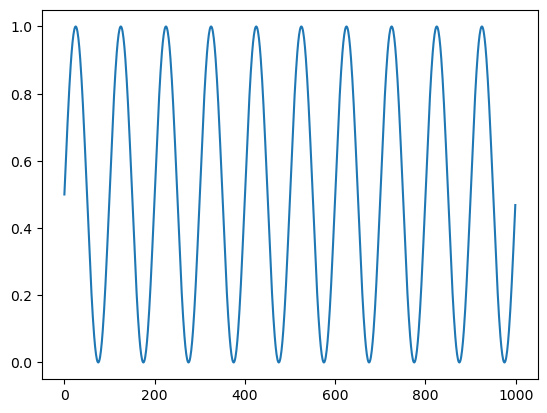

In [44]:
import numpy as np,matplotlib.pyplot as plt

# синусоида из ПЗ2. 
def sine(length=10, resolution=100, shift = 0):
    """length - кол-во повторов, resolution - значений на 1 повтор, shift - смещение фазы (1 = 1 фаза)"""
    return (np.sin(np.arange(start = 2*shift*np.pi, stop = 2*np.pi*length + 2*shift*np.pi, step = (2*np.pi)/resolution))+1)/2

# функция дискретизации из ПЗ2.
def discretize(image, rate=0.12, width_mm = 36):
    intervals = width_mm/rate #300
    rate = len(image)/intervals
    result=[]
    current = 0
    while True:
        try:
            result.append(image[int(current)])
            current+=rate
        except IndexError:  break
    return np.array(result)

# Перевод в 2D изображение
def to_2D(img, r=True):
    img=np.array([img]*len(img))
    if r is True: return img
    import matplotlib.pyplot as plt
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

plt.plot(sine())
plt.show()

Дискретизация сигнала:

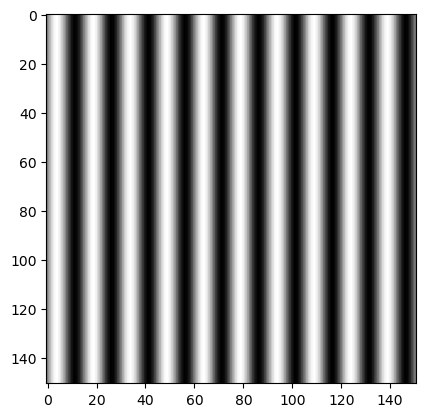

In [45]:
#Дискретизация
image = sine(length=10, resolution=100, shift = 0)
image = discretize(image, rate=0.24, width_mm=36)
to_2D(image*255, False)

Проведено квантование сигнала. Число уровней квантования задается
следующее 2, 8, 32, 64, 128 и 256. Границы интервала квантования [0; 1]
и [0.1; 0.9].

C:\Users\nkshv\AppData\Local\Temp\ipykernel_47788\1681985061.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return round(20 * math.log10(255/(mse(image1, image2)**0.5)), 2)


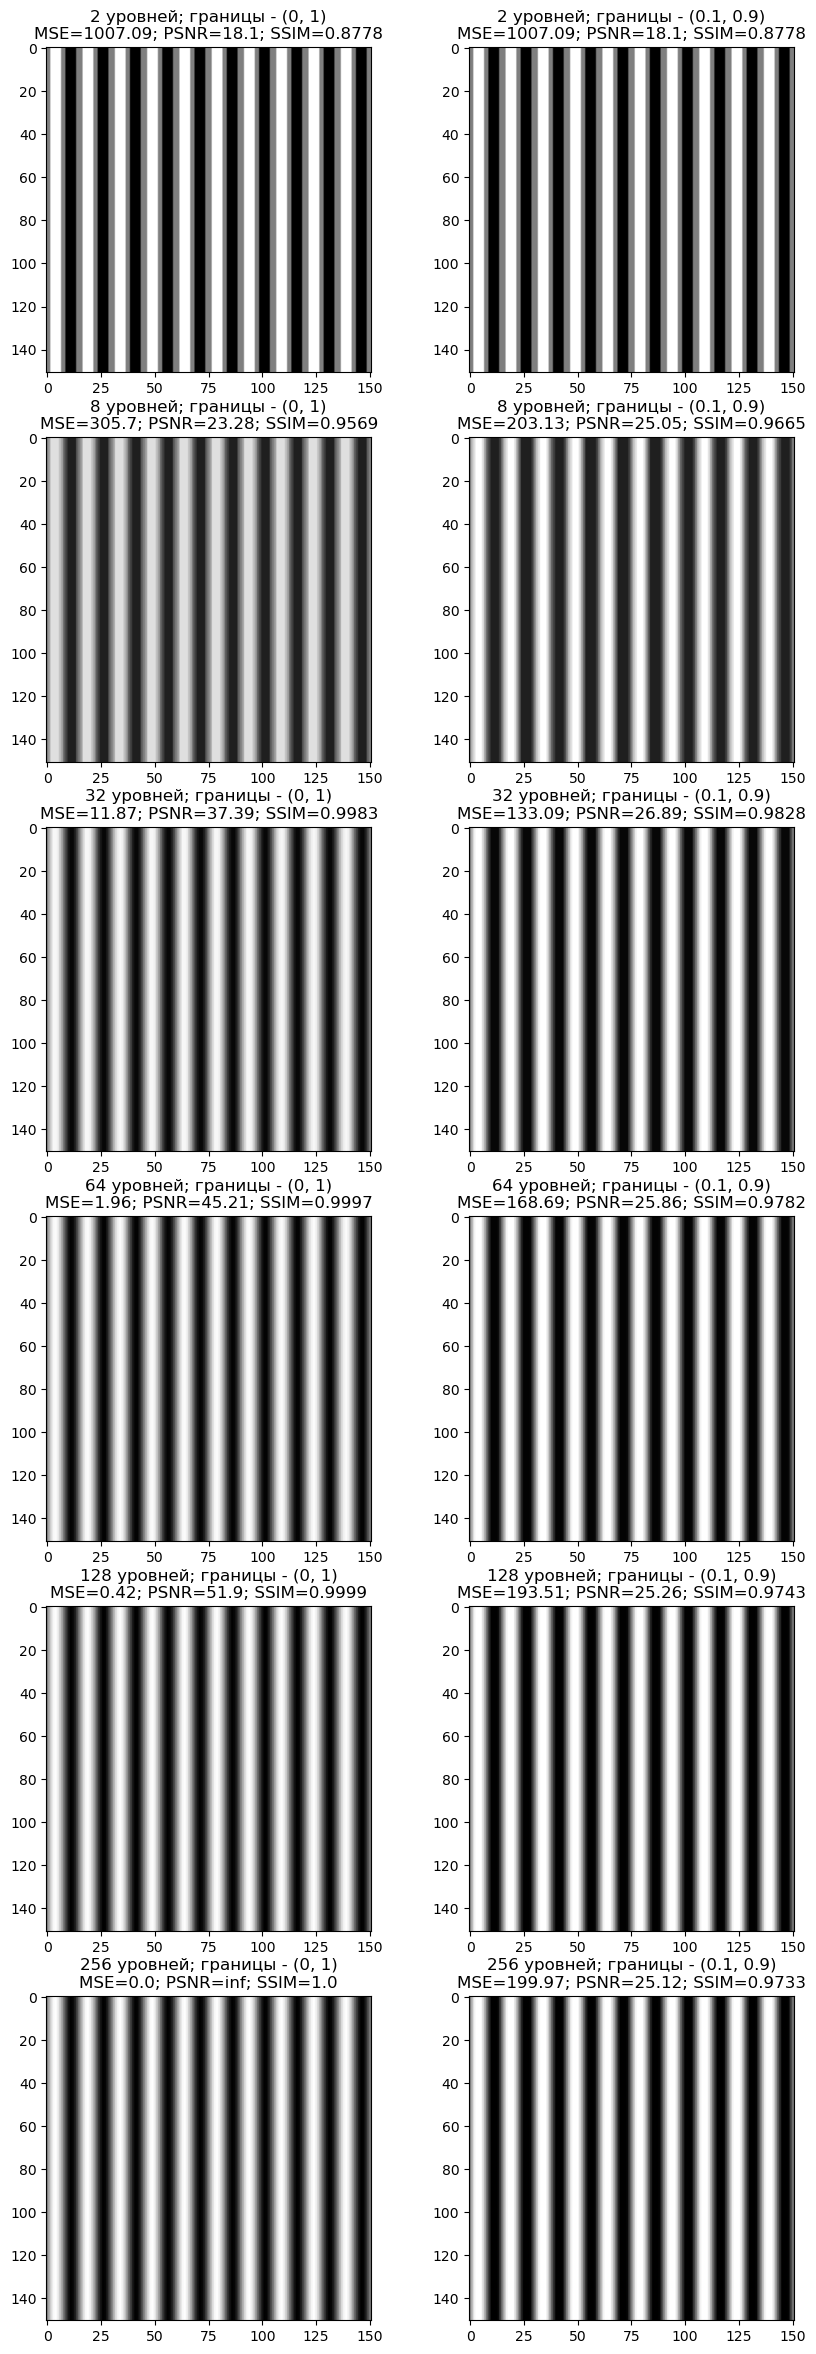

In [46]:
# Метрики
def mse(image1, image2):
    return round(np.sum((image1.astype(int) - image2.astype(int))**2) / image1.size, 2)
def psnr(image1, image2):
    import math
    return round(20 * math.log10(255/(mse(image1, image2)**0.5)), 2)
from skimage.metrics import structural_similarity as ssim2
ssim = lambda a, b: round(ssim2(a, b), 4)


# квантование сигнала с необходимым числом уровней ( [2, 8, 32, 64, 128 , 256]) и для каждого уровня границы [0;1] и [0.1;0.9]
signals=[]
levels = [2, 8, 32, 64, 128 , 256]
limits = [(0, 1), (0.1, 0.9)]
for i in levels:
    for j in limits:
        signals.append(quantize(image.copy(), *j, i))

# Отображение
image255=to_2D(image*255)
def task(signals=signals):
    fig = plt.figure(figsize=(10, 70))
    for n, i in enumerate(signals):
        fig.add_subplot(14, 2, n+1)
        plt.title(f'{levels[int(n/2)%6]} уровней; границы - {limits[n%2]}\nMSE={mse(image255, to_2D(i))}; PSNR={psnr(image255, to_2D(i))}; SSIM={ssim(image255, to_2D(i))}')   
        plt.imshow(to_2D(i), cmap='gray', vmin=0, vmax=255)
task()

Таким образом, увеличение количества уровней квантования приводит к снижению погрешности квантования, что видно по метрикам. При этом согласно метрики SSIM, уже при 8 уровнях квантования различие между исходным изображением и результатом квантования минимально, хотя видны переходы светлоты. Визуально для данного изображения 32 уровня квантования не отличается от более высоких значений. Cужение границ интервала квантования до [0.1;0.9] приводит к снижению показателей схожести изображений, так как в этих изображениях много чёрного и белого цвета, который в результате квантования с такими границами приближается серому.

Для изображения с 8 уровнями квантования улучшены метрики с использованием неравномерного квантования. Для этого самостоятельно заданы уровни квантования на основании гистограммы исходного изображения.


(array([16.97107247,  0.        ,  0.        , 10.18264348,  0.        ,
         6.78842899,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 16.97107247,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 16.97107247,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  6.78842899,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 10.18264348,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

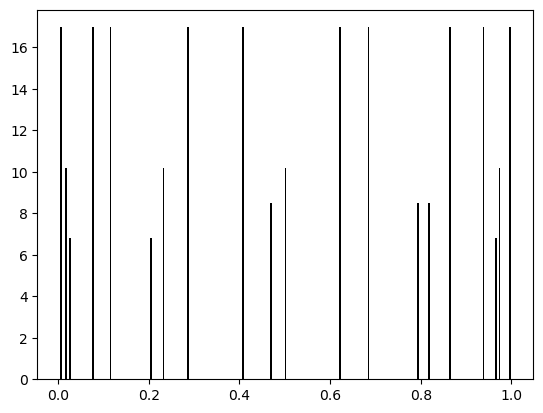

In [47]:
plt.hist(image.flatten(), bins = 255, density=True, stacked=True, color='black')

Таким образом, можно увидеть некоторое распределение значений пикселей в дискретизированном изображении, и найти такие восемь уровней для неравномерного квантования, которые позволят уменьшить погрешность квантования. Их можно найти методом k-средних:

d:\Mambaforge\envs\uni\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Mambaforge\envs\uni\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Уровни неравномерного квантования:  [0.011, 0.096, 0.256, 0.406, 0.485, 0.655, 0.838, 0.969]

Метрики при равномерном квантовании с 8 уровнями:
MSE = 305.7;
PSNR = 23.28;
SSIM=0.9569

nМетрики при неравномерном квантовании с 8 уровнями:
MSE = 297.87;
PSNR = 23.39;
SSIM=0.9585

Изображение неравномерного квантования с 8 уровнями:


d:\Mambaforge\envs\uni\Lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


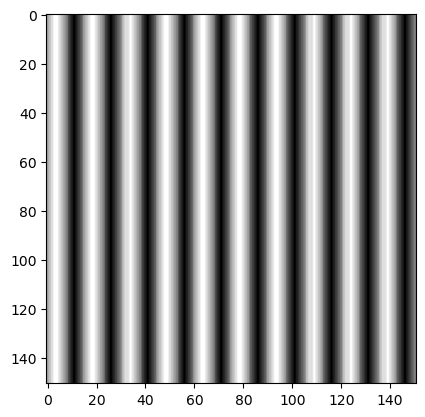

In [48]:
from sklearn.cluster import MiniBatchKMeans
k_means = MiniBatchKMeans(8, compute_labels=False)
k_means.fit(image.reshape(-1, 1))
print('Уровни неравномерного квантования: ', [round(i[0], 3) for i in sorted(k_means.cluster_centers_)])
cv2.imwrite('sine.png', to_2D(signals[-2]))
image_reg = quantize(image.copy(), 0, 1, 8)
image_irr = quantize(image.copy(), 0, 1, [i[0] for i in sorted(k_means.cluster_centers_)])
to_2D(image_irr, False)
print(f'\nМетрики при равномерном квантовании с 8 уровнями:')
print(f'MSE = {mse(image255, to_2D(image_reg))};\nPSNR = {psnr(image255, to_2D(image_reg))};\nSSIM={ssim(image255, to_2D(image_reg))}')
print(f'\nnМетрики при неравномерном квантовании с 8 уровнями:')
print(f'MSE = {mse(image255, to_2D(image_irr))};\nPSNR = {psnr(image255, to_2D(image_irr))};\nSSIM={ssim(image255, to_2D(image_irr))}')
print('\nИзображение неравномерного квантования с 8 уровнями:')

Таблица полученных метрик:
| Номер изображения | 1     | 2         | 3      | 4      | 5      | 6     | 7     | 8      | 9      | 10     | 11     | 12     |
| ----------------- | ----- | --------- | ------ | ------ | ------ | ----- | ----- | ------ | ------ | ------ | ------ | ------ |
| Границы интервала |[0;1]||||||[0.1;0.9]|
| Число уровней     | 2     | 8         | 32     | 64     | 128    | 256   | 2     | 8      | 32     | 64     | 128    | 256    |
| MSE               | 1847  | 107       | 7.63   | 1.93   | 0.58   | 0.13  | 2446  | 429.14 | 184.15 | 167.54 | 152.09 | 137.7  |
| PNSR              | 15.5  | 27.8      | 39.3   | 45.28  | 50.5   | 56.99 | 14.24 | 21.8   | 25.48  | 25.89  | 26.31  | 26.74  |
| SSIM              | 0.66  | 0.98      | 0.9988 | 0.9997 | 0.9999 | 1     | 0.59  | 0.92   | 0.9708 | 0.9728 | 0.9753 | 0.9776 |

## Вывод
Таким образом, для квантования, т.е. представления амплитуды значениями из конечного множества, следует минимизировать погрешность квантования путём подбора оптимального количества уровней квантования, однако при достижении определенной погрешности дальнейшее повышение количества уровней квантования будет приводить лишь к несущественному снижению погрешности, что не всегда целесообразно. В данной работе продемонстрировано, что при использовании равномерного квантования, для визуального сохранения изображения достаточно 32-х уровней квантования.

Также можно значительно снизить погрешность квантования без увеличения количества уровней квантования - путём подбора уровней для неравномерного квантования на основе распределения значений исходного сигнала, например, методом k-средних. В данной работе это позволило понизить показатель MSE почти в три раза.